In [1]:
import matplotlib
import mailbox
import email
import re
import datetime
import time
import matplotlib.pyplot as plt
import email.utils
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib.dates import HourLocator, MinuteLocator, DateFormatter
import json
import urllib.request
from scipy import stats
from collections import defaultdict
%matplotlib inline

In [2]:
with open('/Users/spardy/.config/OAUTHS/wunderground.json') as f:
    wunderground_api_key = json.load(f)['KEY']

In [3]:
def get_historical_weather(state, city, date, api_key):
    with urllib.request.urlopen('http://api.wunderground.com/api/' +
                          api_key +
                          '/history_' +
                          date +
                          '/q/' +
                          state +
                          '/' +
                          city +
                          '.json') as response:
        str_response = response.read().decode('utf-8')

        data = json.loads(str_response)
        return data

In [4]:
test_txts = [
"""
5:06pm at the mailboxes.

Woo!

_______________________________________________
Social mailing list
Social@astro.wisc.edu
""",
"""
Meet at the mailboxes in 5 min!

-- 
Jenna E. Ryon
Graduate Student
University of Wisconsin - Madison
Department of Astronomy
475 N Charter St.
Madison, WI 53706

_______________________________________________
Social mailing list
Social@astro.wisc.edu
"""]

In [5]:
for text in test_txts:
    m = re.search("[0-9]:[0-9]{2}", text)
    if m is not None:
        print(m.group())
    else:
        m = re.search("in [0-9] min", text)
        if m is not None:
            print(m.group())
        else:
            print(text)

5:06
in 5 min


In [6]:
mbox = mailbox.mbox('/Users/spardy/Takeout/Mail/Beer.mbox')

In [7]:
skip_indices = [1, 19, 31, 70, 88, 104, 105, 106, 108, 132, 137, 153]

In [8]:
senders = []
for i, message in enumerate(mbox):
    if i in skip_indices:
        continue
    for header in message._headers:
        if header[0] == 'From':
            m = re.search("<(.*)@.*>", header[1])
            if m is not None:
                senders.append(m.groups(1)[0])
            else:
                print(header)

In [10]:
times_sent = np.array([])
times_to_go = np.array([])
mail_indices = np.array([], dtype=int)

for key, value in mbox.iteritems():

    if key in skip_indices:
        continue

        
    #date = datetime.datetime.fromtimestamp(time.mktime(email.utils.parsedate(value['Date'])))
    date = datetime.datetime.fromtimestamp(email.utils.mktime_tz(email.utils.parsedate_tz(value['Date'])))
    
    times_sent = np.append(times_sent, date)
    
    msg = email.message_from_string(value.as_string())
    
    if msg.is_multipart():
        text = msg.get_payload()[0].get_payload()
        if type(text) is list:
            text =','.join(str(v) for v in text)
    else:
        text = msg.get_payload()
        
    m = re.search("([0-9]):([0-9]{2})", text)
    if m is not None:
        hour = int(m.group(1))
        minute = int(m.group(2))
        new_date = date.replace(hour=hour+12, minute=minute)
        times_to_go = np.append(times_to_go, new_date)
        mail_indices = np.append(mail_indices, key)
    else:
        m = re.search("([0-9])pm", text)
        if m is not None:
            hour = int(m.group(1)[0])
            new_date = date.replace(hour=hour+12, minute=0)
            times_to_go = np.append(times_to_go, new_date)
            mail_indices = np.append(mail_indices, key)
        else: 
            m = re.search("in ([0-9]+) min", text)
            if m is not None:
                minutes = int(m.groups(1)[0])
                new_date = date + datetime.timedelta(minutes = minutes)
                times_to_go = np.append(times_to_go, new_date)
                mail_indices = np.append(mail_indices, key)
            else:
                times_to_go = np.append(times_to_go, date)
                mail_indices = np.append(mail_indices, key)
                #print(key, text)
    


In [11]:
def get_beer_time(date):
    return date.replace(year=2000, month=1, day=1)
    
beer_times = list(map(get_beer_time, times_to_go))

beer_timestamps = np.array(list(map(lambda t: t.timestamp(), beer_times)))


In [12]:
times_by_sender = defaultdict(list)
for sender, time in zip(senders, beer_times):
    times_by_sender[sender].append(time)


In [13]:
times_by_sender

defaultdict(list,
            {'andrew': [datetime.datetime(2000, 1, 1, 16, 38, 21)],
             'bard': [datetime.datetime(2000, 1, 1, 16, 40, 21),
              datetime.datetime(2000, 1, 1, 16, 41, 27),
              datetime.datetime(2000, 1, 1, 17, 15, 21)],
             'boettche': [datetime.datetime(2000, 1, 1, 16, 45, 4)],
             'burkhart': [datetime.datetime(2000, 1, 1, 16, 42, 6),
              datetime.datetime(2000, 1, 1, 16, 13, 13)],
             'casanova': [datetime.datetime(2000, 1, 1, 16, 30, 30)],
             'chisholm': [datetime.datetime(2000, 1, 1, 16, 30, 50)],
             'cmurray': [datetime.datetime(2000, 1, 1, 16, 35, 21)],
             'ebc': [datetime.datetime(2000, 1, 1, 17, 3, 7)],
             'edonghia': [datetime.datetime(2000, 1, 1, 16, 30, 32)],
             'eigenbrot': [datetime.datetime(2000, 1, 1, 16, 43, 33),
              datetime.datetime(2000, 1, 1, 16, 45, 13),
              datetime.datetime(2000, 1, 1, 16, 33, 58),
             

In [14]:
timestamp_by_sender = {key: [t.timestamp() for t in value]
                       for key, value in times_by_sender.items()}


In [21]:
for k, t in timestamp_by_sender.items():
    if len(t) > 3:
        print(k, len(t))

ryon 14
wood 9
spardy 6
frenchd 9
eigenbrot 38
tofflemi 19
zpace 26
leiner 4


ryon 14
wood 9
spardy 6
frenchd 9
eigenbrot 38
tofflemi 19
zpace 26
leiner 4


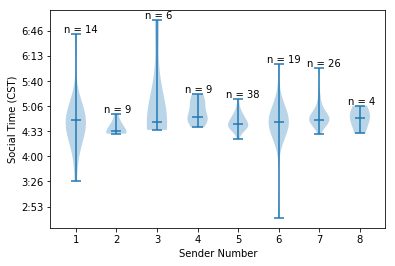

In [22]:
fig, axis = plt.subplots(1)

data = []

for k, t in timestamp_by_sender.items():
    if len(t) > 3:
        data.append(t)
        print(k, len(t))

#data = [t for t in timestamp_by_sender.values() if len(t) > 3]
plt.violinplot(data, showmedians=True)
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
axis.yaxis.set_major_formatter(y_formatter)
plt.draw()

for i, datum in enumerate(data):
    axis.text(i+0.7, np.max(datum)+100, "n = {:d}".format(len(datum)))

labels = [item.get_text() for item in axis.get_yticklabels()]
for i, label in enumerate(labels):
    if label:
        label_date = datetime.datetime.fromtimestamp(float(label)*1e+8)
        labels[i] = "{:d}:{:02d}".format(label_date.hour-12, label_date.minute)
    
_ = axis.set_yticklabels(labels)
axis.set_xlabel("Sender Number")
axis.set_ylabel("Social Time (CST)")

#fig.savefig('./beertimes_by_sender.jpg', dpi=600)

In [68]:
for key, value in times_by_sender.items():
    ts = [t.timestamp() for t in value]
    median_ts = np.median(ts)
    median_time = datetime.datetime.fromtimestamp(median_ts)
    
    if len(value) > 1:
        print(key, len(value), median_time.hour, median_time.minute)

frenchd 9 16 52
khall 3 17 4
eigenbrot 38 16 43
nhill 3 16 41
leiner 4 16 51
krishnarao 3 16 55
gosnell 2 16 21
zpace 26 16 48
jdavis 2 16 52
burkhart 2 16 27
wood 9 16 33
bard 3 16 41
tofflemi 19 16 45
spardy 6 16 45
ryon 14 16 47


In [49]:
def running_median(x, width, upper=90, lower=10):
    if width % 2 == 0:
        width += 1
    
    N = width // 2
    
    def make_window(x, i):
        ln = len(x)
        start = i - N if i > N else 0
        end = i + N if i < ln - N else ln
        return x[start:end]
    
    medians = np.empty_like(x)
    upper_perc = np.empty_like(x)
    lower_perc = np.empty_like(x)
    
    for i in range(len(x)):
        window = make_window(x, i)
        medians[i] = np.median(window)
        upper_perc[i] = np.percentile(window, upper)
        lower_perc[i] = np.percentile(window, lower)
        
    return medians, upper_perc, lower_perc
    

In [50]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [13]:
#Averaging

s = np.argsort(times_sent)

sorted_sent_times = times_sent[s]
sorted_beer_times = beer_timestamps[s]

window_size = 11

end_size = window_size // 2

avg_beer_time, upper_beer_time, lower_beer_time = running_median(sorted_beer_times,
                                                                 window_size, upper=75, lower=25)

#avg_beer_time = running_mean(sorted_beer_times, window_size)
avg_beer_datetimes = np.array(list(map(lambda t: datetime.datetime.fromtimestamp(t), avg_beer_time)))
upper_beer_datetimes = np.array(list(map(lambda t: datetime.datetime.fromtimestamp(t), upper_beer_time)))
lower_beer_datetimes = np.array(list(map(lambda t: datetime.datetime.fromtimestamp(t), lower_beer_time)))


In [11]:
avg_beer_datetimes[0:2]

array([datetime.datetime(2000, 1, 1, 16, 30, 37),
       datetime.datetime(2000, 1, 1, 16, 31, 58, 500000)], dtype=object)

In [12]:
avg_beer_datetimes[-2:]

array([datetime.datetime(2000, 1, 1, 16, 51, 22),
       datetime.datetime(2000, 1, 1, 16, 48, 37, 500000)], dtype=object)

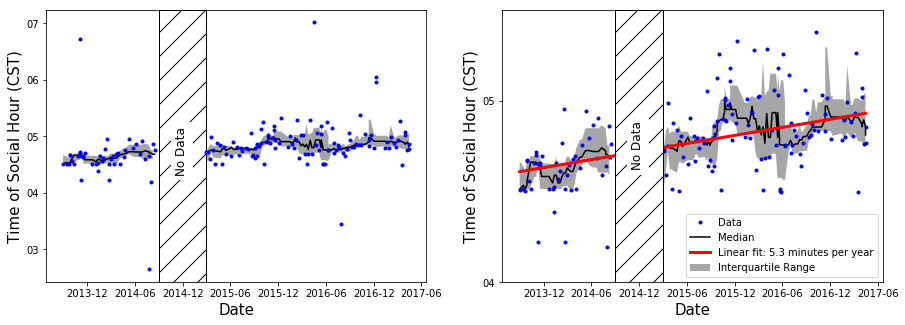

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hours = HourLocator()
minutes = MinuteLocator()
hoursFmt = DateFormatter('%I')

# format the ticks
axes[0].yaxis.set_major_locator(hours)
axes[0].yaxis.set_major_formatter(hoursFmt)
#axis.yaxis.set_minor_locator(minutes)
axes[0].autoscale_view()

axes[0].set_xlabel('Date', fontsize=15)
axes[0].set_ylabel('Time of Social Hour (CST)', fontsize=15)

axes[0].plot(times_sent, beer_times, 'b.')

axes[0].plot(sorted_sent_times[sorted_sent_times < datetime.datetime(2015, 1, 1)],
             avg_beer_datetimes[sorted_sent_times < datetime.datetime(2015, 1, 1)], 'k-', zorder=-1)

axes[0].plot(sorted_sent_times[sorted_sent_times > datetime.datetime(2015, 3, 1)],
             avg_beer_datetimes[sorted_sent_times > datetime.datetime(2015, 3, 1)], 'k-', zorder=-1)

axes[0].fill_between(sorted_sent_times, upper_beer_datetimes, lower_beer_datetimes,
                     where=sorted_sent_times < datetime.datetime(2014, 8, 15),
                     facecolor='gray', interpolate=True, zorder=-10, alpha=0.7)

axes[0].fill_between(sorted_sent_times, upper_beer_datetimes, lower_beer_datetimes,
                     where=sorted_sent_times > datetime.datetime(2015, 3, 1),
                     facecolor='gray', interpolate=True, zorder=-10, alpha=0.7)


axes[0].fmt_ydata = DateFormatter('%I:%M')

axes[0].axvspan(datetime.datetime(2014, 9, 1), datetime.datetime(2015, 3, 1),
                hatch='/', facecolor='white', edgecolor='black')
axes[0].text(datetime.datetime(2014, 11, 1), datetime.datetime(2000, 1, 1, 17, 0),
             'No Data', rotation=90, fontsize=12, backgroundcolor='white')

# fitting

X = np.array([t.timestamp() for t in sorted_sent_times])
xrange = np.linspace(X.min(), X.max(), 100)
X = sm.add_constant(X)
Y = np.array([t.timestamp() for t in avg_beer_datetimes])

model = sm.OLS(Y, X)
results = model.fit()

xfit = np.array([datetime.datetime.fromtimestamp(x) for x in xrange])
yfit = np.array([datetime.datetime.fromtimestamp(y) for y in xrange*results.params[1]+results.params[0]])

y1 = 2013
y2 = 2014

t1 = datetime.datetime(year=y1, month=1, day=1)
ts1 = t1.timestamp()*results.params[1]+results.params[0]

t2 = datetime.datetime(year=y2, month=1, day=1)
ts2 = t2.timestamp()*results.params[1]+results.params[0]

slope = (datetime.datetime.fromtimestamp(ts2) - datetime.datetime.fromtimestamp(ts1)).seconds/60.  # mins per year

# format the ticks

axes[1].yaxis.set_major_locator(HourLocator())
axes[1].yaxis.set_major_formatter(hoursFmt)
#axis.yaxis.set_minor_locator(minutes)
#axis.autoscale_view()

axes[1].set_xlabel('Date', fontsize=15)
axes[1].set_ylabel('Time of Social Hour (CST)', fontsize=15)

axes[1].plot(times_sent, beer_times, 'b.', label='Data')

axes[1].plot(sorted_sent_times[sorted_sent_times < datetime.datetime(2015, 1, 1)],
             avg_beer_datetimes[sorted_sent_times < datetime.datetime(2015, 1, 1)], 'k-', zorder=-1)

axes[1].plot(sorted_sent_times[sorted_sent_times > datetime.datetime(2015, 3, 1)],
             avg_beer_datetimes[sorted_sent_times > datetime.datetime(2015, 3, 1)], 'k-', zorder=-1,
             label='Median')

axes[1].fill_between(sorted_sent_times, upper_beer_datetimes, lower_beer_datetimes,
                     where=sorted_sent_times < datetime.datetime(2014, 8, 15),
                     facecolor='gray', interpolate=True, zorder=-10, alpha=0.7)

axes[1].fill_between(sorted_sent_times, upper_beer_datetimes, lower_beer_datetimes,
                     where=sorted_sent_times > datetime.datetime(2015, 3, 1),
                     facecolor='gray', interpolate=True, zorder=-10, alpha=0.7,
                     label='Interquartile Range')

axes[1].fmt_ydata = DateFormatter('%I:%M')

axes[1].set_ylim([datetime.datetime(2000, 1, 1, 16), datetime.datetime(2000, 1, 1, 17, 30)])



axes[1].plot(xfit, yfit, linewidth=3, color='red', label='Linear fit: {:1.1f} minutes per year'.format(slope))

axes[1].axvspan(datetime.datetime(2014, 9, 1), datetime.datetime(2015, 3, 1),
                hatch='/', facecolor='white', edgecolor='black', zorder=3)
axes[1].text(datetime.datetime(2014, 11, 1), datetime.datetime(2000, 1, 1, 16, 50),
             'No Data', rotation=90, fontsize=12, backgroundcolor='white')


axes[1].legend()

plt.savefig('./beer_email_analysis.jpg', dpi=600)

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     301.5
Date:                Sat, 29 Apr 2017   Prob (F-statistic):           6.58e-38
Time:                        10:38:49   Log-Likelihood:                -1068.4
No. Observations:                 154   AIC:                             2141.
Df Residuals:                     152   BIC:                             2147.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       9.468e+08    840.207   1.13e+06      0.000      9.47e+08  9.47e+08
x1          1.014e-05   5.84e-07     17.363      0.000      8.98e-06  1.13e-05
==============================================================================
Omnibus:                        9.399   Durbin-Watson:                   0.302
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.856
Skew:                           0.620   Prob(JB):                      0.00724
Kurtosis:                       3.011   Cond. No.                     5.98e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
for y in range(2017, 2100, 10):
    t = datetime.datetime(year=y, month=1, day=1)
    ts = t.timestamp()*results.params[1]+results.params[0]
    print(y, datetime.datetime.fromtimestamp(ts))

2017 2000-01-01 16:54:16.249951
2027 2000-01-01 17:47:35.291488
2037 2000-01-01 18:40:55.208994
2047 2000-01-01 19:34:14.250530
2057 2000-01-01 20:27:34.168036
2067 2000-01-01 21:20:53.209572
2077 2000-01-01 22:14:13.127079
2087 2000-01-01 23:07:32.168615
2097 2000-01-02 00:00:52.086121


In [74]:
yearly_cycle = np.zeros_like(times_sent)
beer_offsets = np.zeros_like(times_sent)
beer_norm_times = np.zeros_like(times_sent)
for i, (beer_time, time_sent) in enumerate(zip(beer_times, times_sent)):
    pred = time_sent.timestamp()*results.params[1]+results.params[0]
    offset = beer_time - datetime.datetime.fromtimestamp(pred)
    beer_offsets[i] = offset
    yearly_cycle[i] = time_sent.replace(year=2000)
    beer_norm_times[i] = beer_time + offset

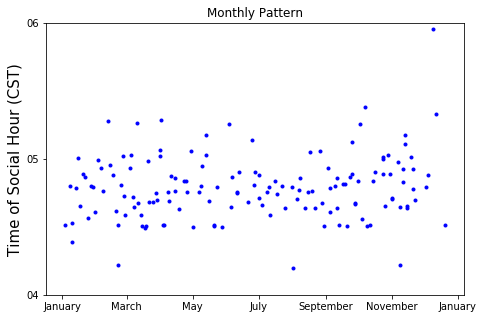

In [155]:
fig, axis = plt.subplots(1, figsize=(7.5, 5))

hours = HourLocator()
minutes = MinuteLocator()
hoursFmt = DateFormatter('%I')

# format the ticks
axis.yaxis.set_major_locator(hours)
axis.yaxis.set_major_formatter(hoursFmt)
#axis.yaxis.set_minor_locator(minutes)
axis.autoscale_view()

#axis.set_xlabel('Date', fontsize=15)
axis.set_ylabel('Time of Social Hour (CST)', fontsize=15)

axis.plot(yearly_cycle, beer_times, 'b.')

axis.set_ylim([datetime.datetime(2000, 1, 1, 16), datetime.datetime(2000, 1, 1, 18)])

axis.xaxis.set_major_formatter(DateFormatter('%B'))
axis.set_title('Monthly Pattern')
fig.savefig('monthly_beer_pattern.jpg', dpi=300)

In [150]:
stats.spearmanr(yearly_cycle, beer_times)

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=0.13182613867569742, pvalue=0.1031625173948847)

In [132]:
max_temps = np.zeros_like(times_sent)
for i, time_sent in enumerate(times_sent):
    date = "{:d}{:02d}{:02d}".format(time_sent.year, time_sent.month, time_sent.day)
    hist_weather_data = get_historical_weather('WI', 'Madison', date, wunderground_api_key)
    max_temp = hist_weather_data['history']['dailysummary'][0]['maxtempi']
    max_temps[i] = max_temp

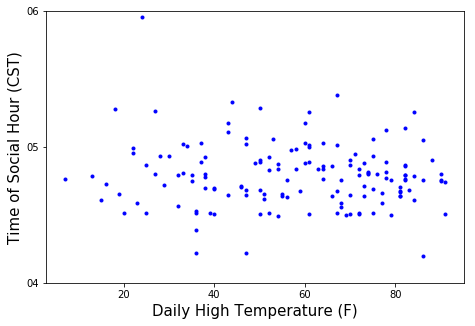

In [156]:
fig, axis = plt.subplots(1, figsize=(7.5, 5))

hours = HourLocator()
minutes = MinuteLocator()
hoursFmt = DateFormatter('%I')

# format the ticks
axis.yaxis.set_major_locator(hours)
axis.yaxis.set_major_formatter(hoursFmt)
#axis.yaxis.set_minor_locator(minutes)
axis.autoscale_view()

axis.set_xlabel('Daily High Temperature (F)', fontsize=15)
axis.set_ylabel('Time of Social Hour (CST)', fontsize=15)

axis.plot(max_temps, beer_times, 'b.')
axis.set_ylim([datetime.datetime(2000, 1, 1, 16), datetime.datetime(2000, 1, 1, 18)])
fig.savefig('temperature_beer.jpg', dpi=300)


In [151]:
stats.spearmanr(max_temps, beer_times)

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


SpearmanrResult(correlation=-0.087406252241794324, pvalue=0.28107381778942692)